In [1]:
#!/usr/bin/env python3
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# -------------------------------
# 1. Load the trained model
# -------------------------------
class BulkAE(nn.Module):
    def __init__(self, n_genes, latent_dim=320):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(n_genes, 4096), nn.ReLU(),
            nn.Linear(4096, 1024), nn.ReLU(),
            nn.Linear(1024, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 1024), nn.ReLU(),
            nn.Linear(1024, 4096), nn.ReLU(),
            nn.Linear(4096, n_genes)
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat, z


# -------------------------------
# 2. Load Test Data
# -------------------------------
TEST_PARQUET = "./data/archs4/processed_short_proteins/test_expr_logtpm_short.parquet"
test_df = pd.read_parquet(TEST_PARQUET)
X_test = test_df.T.astype(np.float32).values
n_samples, n_genes = X_test.shape

print(f"Test matrix: {X_test.shape}")

# metadata
meta = pd.read_csv("./data/archs4/processed_short_proteins/test_metadata_short.csv")
print("Metadata columns:", meta.columns.tolist())

# match sample order
meta = meta.set_index("geo_accession").loc[test_df.columns].reset_index()


# -------------------------------
# 3. Load Trained Weights
# -------------------------------
model = BulkAE(n_genes, latent_dim=320)
model.load_state_dict(torch.load("autoencoder_weights.pt", map_location="cpu"))
model.eval()

# -------------------------------
# 4. Extract Latent Embeddings
# -------------------------------
with torch.no_grad():
    X_tensor = torch.from_numpy(X_test)
    _, Z = model(X_tensor)    # shape: [n_samples, latent_dim]
    Z = Z.numpy()

print("Latent:", Z.shape)





Test matrix: (9446, 19357)
Metadata columns: ['geo_accession', 'characteristics_ch1', 'source_name_ch1', 'text', 'tcga_label']
Latent: (9446, 320)


Running TSNE on raw counts...
Running TSNE on latent...


/tmp/ipykernel_39574/1291386710.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", num_labels)


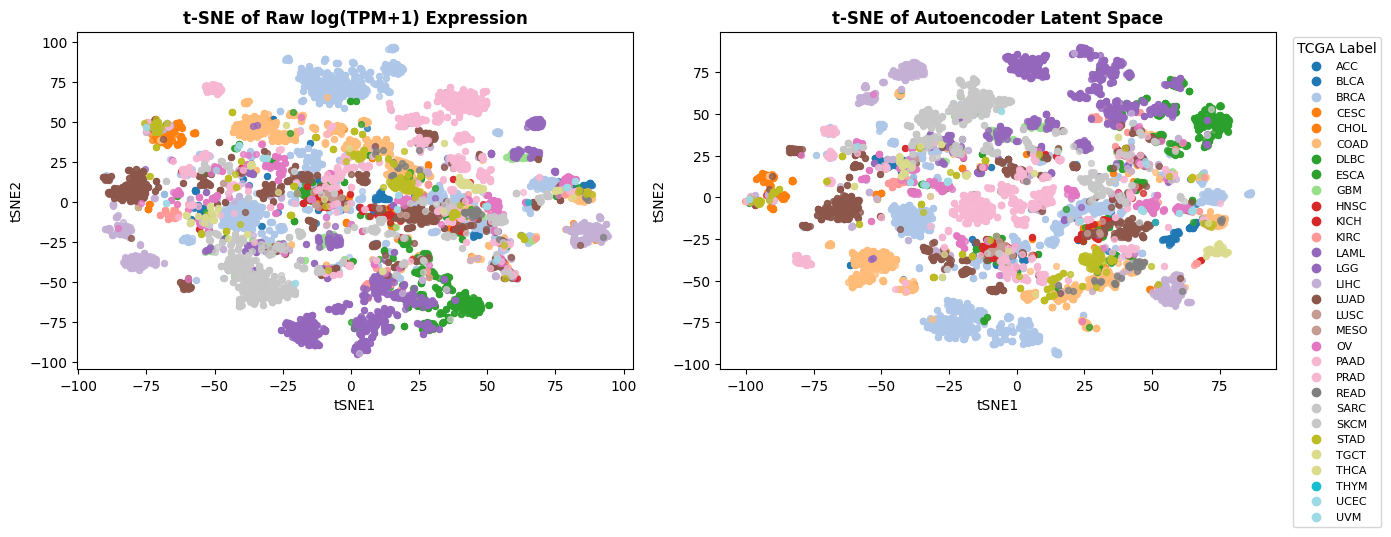

In [2]:
# -------------------------------
# 5. Run t-SNE
# -------------------------------
print("Running TSNE on raw counts...")
tsne_raw = TSNE(n_components=2, perplexity=30, learning_rate="auto").fit_transform(X_test)

print("Running TSNE on latent...")
tsne_latent = TSNE(n_components=2, perplexity=30, learning_rate="auto").fit_transform(Z)

# -------------------------------
# 6. Plotting (Cleaned Up)
# -------------------------------
labels = meta["tcga_label"].astype("category")
label_names = labels.cat.categories
num_labels = len(label_names)

# Deterministic colormap
cmap = plt.cm.get_cmap("tab20", num_labels)

# For each sample, map category code → RGBA color
colors = labels.cat.codes.values
point_colors = cmap(colors)

plt.figure(figsize=(14, 5))

# ===== RAW =====
ax1 = plt.subplot(1, 2, 1)
for i, label in enumerate(label_names):
    mask = (colors == i)
    ax1.scatter(
        tsne_raw[mask, 0], tsne_raw[mask, 1],
        color=cmap(i),
        s=18,
        alpha=0.75,
        label=label
    )
ax1.set_title("t-SNE of Raw log(TPM+1) Expression", fontsize=12, fontweight='bold')
ax1.set_xlabel("tSNE1")
ax1.set_ylabel("tSNE2")

# ===== LATENT =====
ax2 = plt.subplot(1, 2, 2)
for i, label in enumerate(label_names):
    mask = (colors == i)
    ax2.scatter(
        tsne_latent[mask, 0], tsne_latent[mask, 1],
        color=cmap(i),
        s=18,
        alpha=0.75,
        label=label
    )
ax2.set_title("t-SNE of Autoencoder Latent Space", fontsize=12, fontweight='bold')
ax2.set_xlabel("tSNE1")
ax2.set_ylabel("tSNE2")

# ===== Shared Legend =====
# Place ONE legend for both subplots
handles = [
    plt.Line2D([0], [0],
        marker='o',
        linestyle='',
        markersize=6,
        color=cmap(i),
        label=label
    )
    for i, label in enumerate(label_names)
]

plt.legend(
    handles=handles,
    title="TCGA Label",
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    fontsize=8
)

plt.tight_layout()
plt.show()


In [3]:
import numpy as np
import pandas as pd

# Load your raw-ish data (log(TPM+1) or TPM – structure is the same)
PARQUET = "./data/archs4/processed_short_proteins/test_expr_logtpm_short.parquet"
expr_df = pd.read_parquet(PARQUET)

# expr_df shape: [genes × samples]

# Convert to matrix
X = expr_df.values

# Count zeros per gene
zeros_per_gene = (X == 0).sum(axis=1)
nonzeros_per_gene = (X != 0).sum(axis=1)

# Count zeros per sample
zeros_per_sample = (X == 0).sum(axis=0)
nonzeros_per_sample = (X != 0).sum(axis=0)

print(f"\n=== Sparsity Summary ===")
print(f"Matrix shape: {X.shape}")
print(f"Total entries: {X.size:,}")
print(f"Total zeros: {(X==0).sum():,}  ({(X==0).mean()*100:.2f}% of matrix)")
print(f"Total non-zeros: {(X!=0).sum():,}")

print(f"\nGenes with >90% zeros: {(zeros_per_gene > 0.9 * X.shape[1]).sum()}")
print(f"Genes with <10% zeros: {(zeros_per_gene < 0.1 * X.shape[1]).sum()}")

print(f"\nMedian zeros per gene: {np.median(zeros_per_gene):,}")
print(f"Median non-zeros per gene: {np.median(nonzeros_per_gene):,}")

print(f"\nMedian zeros per sample: {np.median(zeros_per_sample):,}")
print(f"Median non-zeros per sample: {np.median(nonzeros_per_sample):,}")



=== Sparsity Summary ===
Matrix shape: (19357, 9446)
Total entries: 182,846,222
Total zeros: 30,329,509  (16.59% of matrix)
Total non-zeros: 152,516,713

Genes with >90% zeros: 822
Genes with <10% zeros: 13093

Median zeros per gene: 94.0
Median non-zeros per gene: 9,352.0

Median zeros per sample: 3,229.0
Median non-zeros per sample: 16,128.0


In [4]:
import os

# Save the latent embeddings

output_dir = "./data/embeddings"
os.makedirs(output_dir, exist_ok=True)

torch.save(Z, os.path.join(output_dir, "ae_gene_latents_320_test_set.pt"))
print(f"Embeddings saved to {output_dir}/ae_gene_latents_320_test_set.pt")

Embeddings saved to ./data/embeddings/ae_gene_latents_320_test_set.pt
